In [1]:
from tabnanny import verbose

from sympy import false

# pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu130
#  pip install stable-baseline[extra] protobuf==3.20.*
#  pip install torchaudio
#  pip install mss pydirectinput pytesseract
print("hello")

hello


In [2]:
# to capture game screen
from mss import mss
# to provide keystroke inputs to the game
import pydirectinput
import cv2
import numpy as np
# to perform OCR on game screen
import pytesseract
from matplotlib import pyplot as plt
import time
# to create custom gym environment
from gymnasium import Env
# to define action and observation space
from gymnasium.spaces import Discrete, Box

In [3]:
# code to detect the objects in image
from ultralytics import YOLO
import cv2

yolo_model = YOLO("yolo_model/best.pt")


def getObjectPositions(observation):
    observation = cv2.cvtColor(observation, cv2.COLOR_GRAY2RGB)
    results = yolo_model.predict(source=observation, conf=0.25, imgsz=640, verbose=False)
    result = results[0]
    boxes = result.boxes

    if len(boxes) == 0:
        return boxes.data,  result.names

    # Group boxes by class and find leftmost for each class
    class_leftmost = {}

    for i, box in enumerate(boxes):
        class_id = int(box.cls)
        x1 = float(box.xyxy[0][0])  # leftmost x coordinate

        # Keep the box with smallest x1 (leftmost) for each class
        if class_id not in class_leftmost or x1 < class_leftmost[class_id]['x1']:
            class_leftmost[class_id] = {'index': i, 'x1': x1}

    # Extract the indices of leftmost boxes for each class
    leftmost_indices = [info['index'] for info in class_leftmost.values()]

    # Return only the leftmost boxes data
    filtered_data = boxes.data[leftmost_indices]
    return filtered_data, result.names



In [4]:
# creating the environment
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(256, 640, 1), dtype=np.uint8)
        self.action_space = Discrete(3)
        # define the extraction parameters for the game
        self.cap = mss()
        monitor_2 = self.cap.monitors[1]  # Use index 2 for second monitor
        # Adjust the coordinates relative to the second monitor
        self.game_location = {
            'top': monitor_2["top"] + 150,
            'left': monitor_2["left"] + 400,  # Start from second monitor's left edge
            'width': 640,
            'height': 256
        }

        self.done_location = {
            'top': monitor_2["top"] + 280,
            'left': monitor_2["left"] + 650,  # Offset from second monitor's left edge
            'width': 600,
            'height': 50
        }

    def step(self, action):
        action_map = {
            0: 'space',
            1: 'down',
            2: 'no_op',
        }
        if action != 2:
            pydirectinput.press(action_map[action])

        new_observation = self.get_observation()

        # Get object positions and names
        try:
            filtered_data, names = getObjectPositions(new_observation)
            reward = self.calculate_reward(filtered_data, names)
        except Exception as e:
            print("Error in object detection or reward calculation:", e)
            reward = -1

        info = {}

        return new_observation, reward, True if reward == -1 else False, False, info

    def calculate_reward(self, filtered_data, names):
        """Calculate reward based on T-Rex position relative to obstacles"""
        # Create reverse mapping for easier lookup
        name_to_id = {v: k for k, v in names.items()}

        # Find objects by type
        trex_box = None
        cactus_box = None
        bird_box = None
        restart_detected = False

        for box in filtered_data:
            class_id = int(box[5])  # class id is at index 5

            if class_id == name_to_id.get('t-rex'):
                trex_box = box
            elif class_id == name_to_id.get('cactus'):
                cactus_box = box
            elif class_id == name_to_id.get('bird'):
                bird_box = box
            elif class_id == name_to_id.get('restart'):
                restart_detected = True

        # If restart button detected, return penalty
        if restart_detected:
            print('restart_detected', end=" | ")
            return -1

        # If no T-Rex detected, return neutral reward
        if trex_box is None:
            return 0

        # Extract T-Rex coordinates and convert to float
        trex_x1, trex_y1, trex_x2, trex_y2 = [float(x) for x in trex_box[:4]]
        trex_center_x = (trex_x1 + trex_x2) / 2
        reward = 0.01

        if cactus_box is not None:
            # Convert cactus coordinates to float
            cactus_x1, cactus_y1, cactus_x2, cactus_y2 = [float(x) for x in cactus_box[:4]]
            cactus_center_x = (cactus_x1 + cactus_x2) / 2

            # Check if T-Rex is horizontally aligned with cactus
            if abs(trex_center_x - cactus_center_x) < 20:
                # If T-Rex is above cactus (lower y value means higher position)
                if trex_y2 < cactus_y1:
                    height_difference = cactus_y1 - trex_y2
                    print("🦖🌵", end=" | ")
                    reward += min(height_difference / 10, 3)

        if bird_box is not None:
            # Convert bird coordinates to float
            bird_x1, bird_y1, bird_x2, bird_y2 = [float(x) for x in bird_box[:4]]
            bird_center_x = (bird_x1 + bird_x2) / 2

            # Check if T-Rex is horizontally aligned with bird
            if abs(trex_center_x - bird_center_x) < 20:
                # Calculate vertical separation
                if trex_y2 < bird_y1 or trex_y1 > bird_y2:
                    height_difference = min(abs(trex_y1 - bird_y2), abs(bird_y1 - trex_y2))
                    print("🦖🐦", end=" | ")
                    reward += min(height_difference / 10, 3)

        print(reward,end=" | ")
        return reward

    def reset(self, seed=None):
        print("restarting game...")
        time.sleep(0.25)
        monitor_2 = self.cap.monitors[1]
        pydirectinput.click(x=monitor_2["left"] + 200, y=monitor_2["top"] + 200)
        pydirectinput.press('space')
        return self.get_observation(), {}

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))
        raw_rgb = raw[:, :, :3].astype(np.uint8)
        gray = cv2.cvtColor(raw_rgb, cv2.COLOR_RGB2GRAY)
        gray = np.expand_dims(gray, axis=-1)
        return gray

    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:, :, :3]
        done = False
        res = pytesseract.image_to_string(done_cap).upper().replace(" ", "").strip()
        if res.__contains__('GA'):
            done = True
        # print("|" + res + "|" + done.__str__())
        return done, done_cap



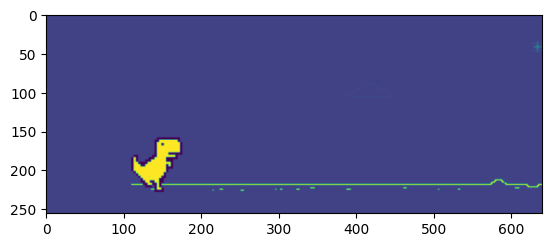

In [5]:
env = WebGame()
plt.imshow(env.get_observation())

In [6]:
getObjectPositions(env.get_observation())

(tensor([[103.5921, 155.6175, 177.4656, 229.8926,   0.8330,   3.0000]], device='cuda:0'),
 {0: 'bird', 1: 'cactus', 2: 'restart', 3: 't-rex'})

In [ ]:
for episodes in range(10):
    obs = env.reset(1)
    done = False
    total_reward = 0
    while not done:
        obs, reward, done, truncated, info = env.step(env.action_space.sample())
        total_reward += reward
    print("total reward:", total_reward, ". for episodes:", episodes)

In [12]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [ ]:
env_checker.check_env(env)

In [13]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [14]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [15]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [16]:
from stable_baselines3 import DQN

In [17]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=8000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


C:\Users\jigya\OneDrive\Desktop\AI_ML_projects\projects\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.62GB > 2.41GB
  warnings.warn(


In [ ]:
model.learn(total_timesteps=50000, callback=callback)

In [18]:
# Load the trained model
model = DQN.load('./train/best_model_50000')

# Test the model
episodes = 5
for episode in range(episodes):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    step_count = 0

    print(f"Episode {episode + 1} starting...")

    while not done and step_count < 1000:
        # Use the trained model to predict actions
        action, _ = model.predict(obs, deterministic=True)
        action = int(action)  # Convert numpy array to scalar

        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        step_count += 1

        # Add small delay to see the gameplay
        time.sleep(0.1)

    print(f"Episode {episode + 1} finished - Total reward: {total_reward}, Steps: {step_count}")


restarting game...
Episode 1 starting...
0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | restart_detected | Episode 1 finished - Total reward: -0.7999999999999999, Steps: 21
restarting game...
Episode 2 starting...
0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 🦖🌵 | 3.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | restart_detected | Episode 2 finished - Total reward: 2.579999999999996, Steps: 59
restarting game...
Episode 3 starting...
0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01